## Homework 4
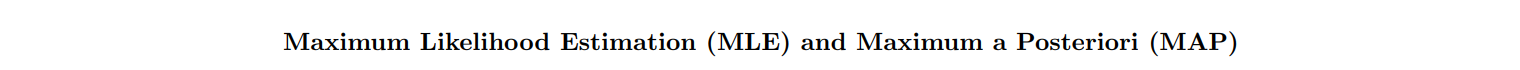
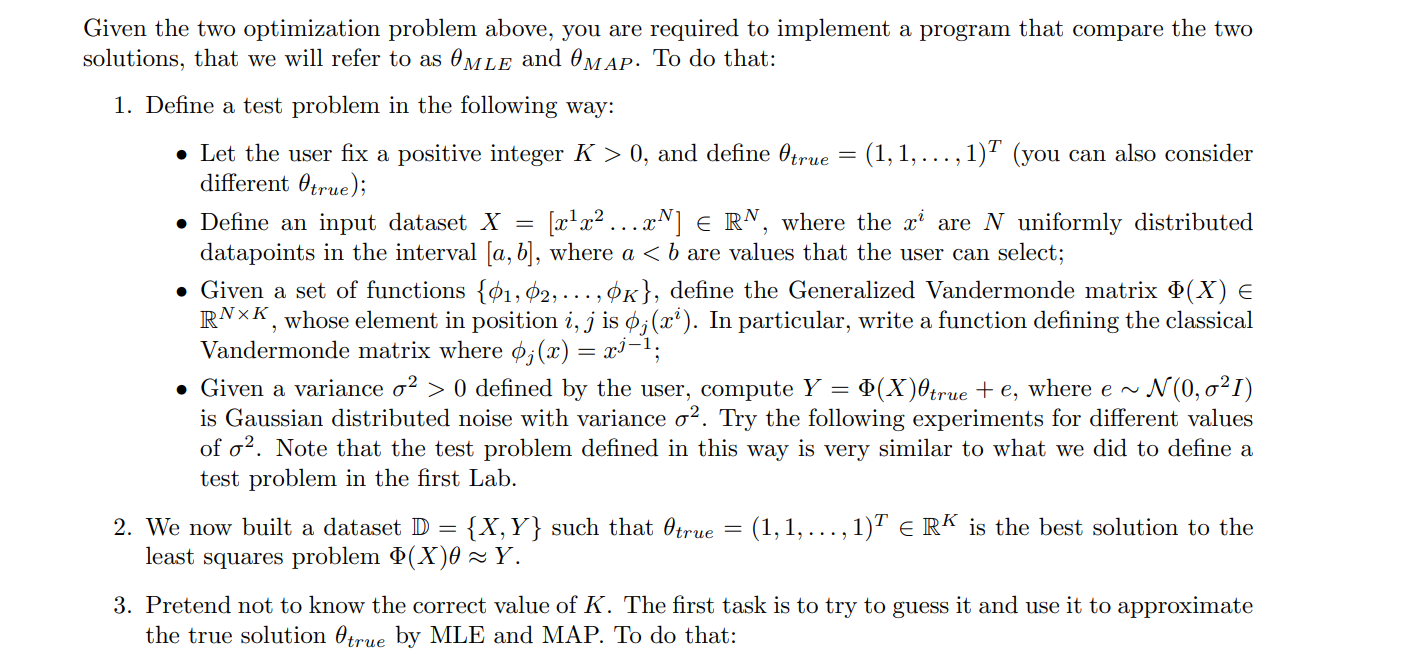
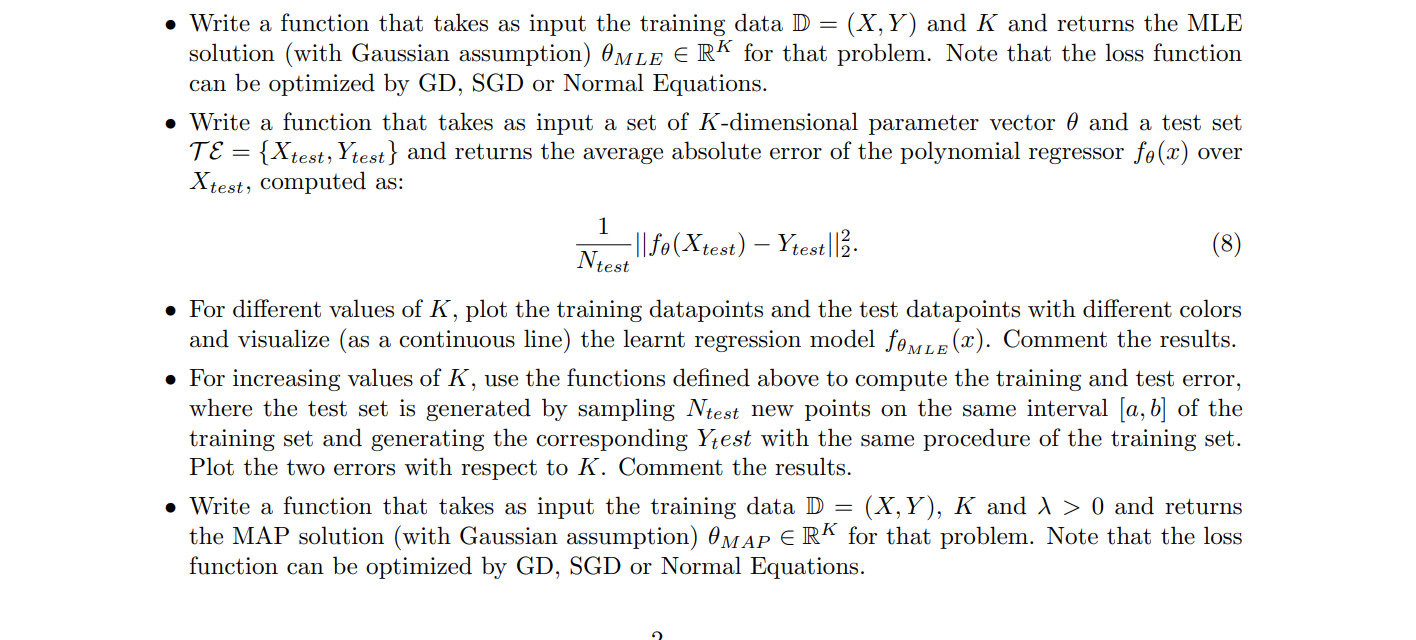
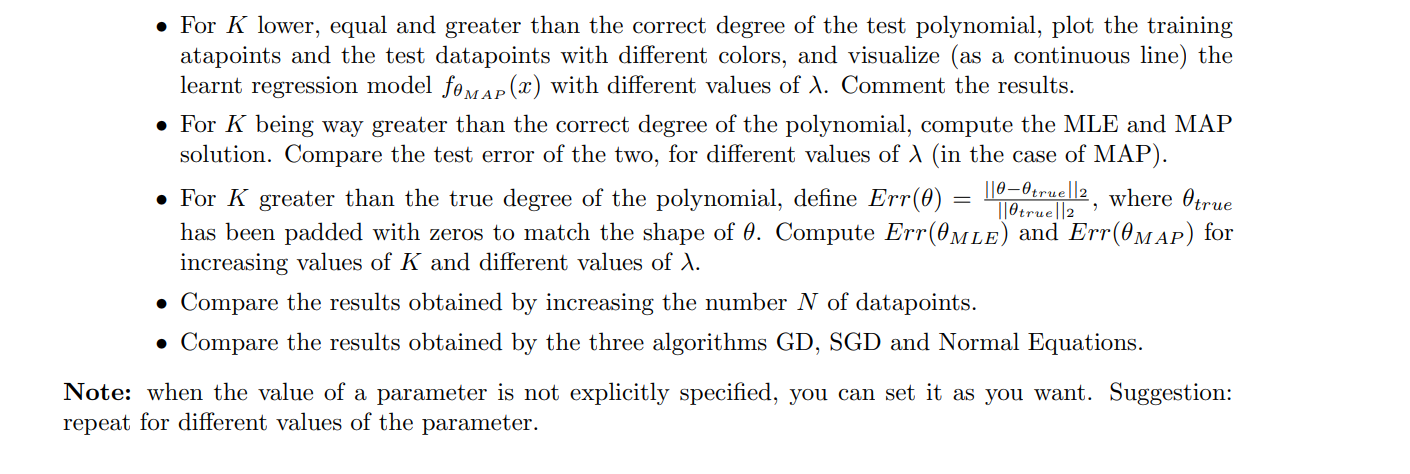

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def backtracking(f, grad_f, x, multivariate):
    
    if multivariate:
        norm = np.linalg.norm
    else:
        norm = np.abs

    alpha = 1
    c = 0.8
    tau = 0.25

    while f(x - alpha * grad_f(x, X, Y), X, Y) > f(x, X, Y) - c * alpha * norm(grad_f(x, X, Y)) ** 2:
        alpha = tau * alpha

        if alpha < 1e-3:
            break
    return alpha


def GD(f, grad_f, x0, kmax, tolf, tolx, back_tracking=False, alpha=1, multivariate=True):
    
    if multivariate:
        norm = np.linalg.norm
    else:
        norm = np.abs

    # Initialize x_k
    x_k = x0

    # counter
    k = 0

    # Loop
    condition = True
    while condition:
        # Update alpha
        if back_tracking:
            alpha = backtracking(f, grad_f, x_k, multivariate)
        # Update x
        x_k = x_k - alpha * grad_f(x_k, X, Y)

        # check criteria
        condition1 = norm(grad_f(x_k, X, Y)) > (tolf * norm(grad_f(x0, X, Y)))
        condition2 = norm(x_k) > tolx
        condition3 = k < kmax
        condition = condition1 and condition2 and condition3

        # update k
        k += 1

    return x_k#, k, np.array(x), np.array(f_val), np.array(grads), np.array(err)


def SGD(loss, grad_loss, w0, D, batch_size, n_epochs, learning_rate=1e-3):
    # Initialize the parameters w
    w = w0
        
    # Extract X and y from D
    X, y = D
    
    # Save in memory the length of X (and y)    They have the same dimension
    N = X.shape[-1]
    
    # We assume that batch_size divides N
    # Compute the number of batches per epoch
    
    n_batch_per_epoch = N // batch_size # integer division in case batch_size doesn't divide N
    
    # Iterate over the epochs
    for epoch in range(n_epochs):
        idx = np.arange(N)
        np.random.shuffle(idx)
        
        # Batch iteration
        for k in range(n_batch_per_epoch):
            X_batch = X[idx[k * batch_size : (k+1) * batch_size]]
            y_batch = y[idx[k * batch_size : (k+1) * batch_size]]
            
            B = (X_batch, y_batch) # it should not be necessary to define B.
            
            gradient = grad_loss(w, X_batch, y_batch)
            w = w - learning_rate * gradient
                        
    return w

def NEQ():
    pass

In [3]:
def vandermonde(X, K):
    N = X.shape[-1]
    Phi = np.zeros((N, K))
    for k in range(K):
        Phi[:, k] = X**k  
    return Phi

# y = 1 - x^2 + x^3 = [x^0, x^1, x^2, x^3] @ [1, 0, -1, 1]
def f(w, X):
    K = w.shape[-1]
    return vandermonde(X, K) @ w

def create_data(a, b, K, N, sigma):
    e = np.random.normal(0, sigma, (N,))
    X = np.linspace(a, b, N)
    Y = f(theta_true, X) + e 
    return X, Y

def train_test_split(X, Y, N_train):
    idx = np.arange(0,X.shape[-1])
    np.random.shuffle(idx)
    X_train = X[idx[:N_train]]
    y_train = Y[idx[:N_train]]
    X_test = X[idx[N_train:]]
    y_test =Y[idx[N_train:]]
    
    return X_train, X_test, y_train, y_test

### Some consideration
For the loss and grad loss functions, $\sigma$ parameter can influence the seek for the minimum, especially if it is small or if high learning rate are involved for the GD. For this reason, if backtracking is active or if i'm using SGD, i minimize the function neglecting sigma. 

## Defining MLE and MAP models

In [37]:
def fit_MLE(D, K, min_f, lamb=None):
    X, Y = D
    
    def loss(theta, X, Y):
        if not back_tracking or min_f is SGD:
            return (1/(2*sigma**2))*np.linalg.norm(f(theta,X)-Y,2)**2 
        return (np.linalg.norm(f(theta,X)-Y,2)**2)/2 # i consider this, since sigma is influencing my seek for the minimum 
    
    def grad_loss(theta, X, Y):
        if not back_tracking or min_f is SGD:
            return (1/sigma**2)*vandermonde(X,K).T@(f(theta,X)-Y) # here sigma seem very important.
        return vandermonde(X,K).T@(f(theta,X)-Y)        
    
    def n_eq(theta, X, Y):
        return np.linalg.inv(vandermonde(X,K).T@vandermonde(X,K))@vandermonde(X,K).T@Y
        
    
    theta = np.random.normal(a,b,K)

    if min_f is GD:
        theta_sol = min_f(loss, grad_loss, theta, kmax, tolf, tolx, back_tracking, alpha, multivariate=True)
    elif min_f is SGD:
        theta_sol = min_f(loss, grad_loss, theta, D, batch_size, n_epochs, learning_rate)
    elif min_f is NEQ:
        theta_sol = n_eq(theta, X, Y)
    else:
        raise ValueError(f"{min_f} is not a valid function for finding the minimum of the loss function!")
    
    return theta_sol

In [38]:
def fit_MAP(D, K, min_f, lamb=0.1):
    X, Y = D
    
    def loss(theta, X, Y):
        if not back_tracking or min_f is SGD:
            return (1/(2*sigma**2))*np.linalg.norm(f(theta,X)-Y,2)**2 + (lamb/2)*np.linalg.norm(theta)**2
        return (1/2)*np.linalg.norm(f(theta,X)-Y,2)**2 + (lamb/2)*np.linalg.norm(theta)**2    
    
    def grad_loss(theta, X, Y):
        if not back_tracking or min_f is SGD:
            return (1/sigma**2)*vandermonde(X,K).T@(f(theta,X)-Y) + lamb*theta
        return vandermonde(X,K).T@(f(theta,X)-Y) + lamb*theta
    
    def n_eq(theta, X, Y):
        return np.linalg.inv(vandermonde(X,K).T@vandermonde(X,K) + lamb*np.identity(K))@vandermonde(X,K).T@Y
   
    
    theta = np.random.normal(a,b,K)
    
    if min_f is GD:
        theta_sol = min_f(loss, grad_loss, theta, kmax, tolf, tolx, back_tracking, alpha, multivariate=True)
    elif min_f is SGD:
        theta_sol = min_f(loss, grad_loss, theta, D, batch_size, n_epochs, learning_rate)
    elif min_f is NEQ:
        theta_sol = n_eq(theta, X, Y)
    else:
        raise ValueError(f"{min_f} is not a valid function for finding the minimum of the loss function!")
    return theta_sol

## Defining the plotting functions

In [6]:
def plot_data(ks, fit, min_f, lamb):
    error_train, error_test = [],[]
    x_axis = np.linspace(a,b,1000) # for printing the curves

    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(X_train, y_train, '.', alpha=0.25, label="Train data")
    plt.plot(X_test, y_test, '.', alpha=0.5, label="Test data")

    for k in ks:
        theta = fit(D, k, min_f, lamb)
        plt.plot(x_axis, f(theta, x_axis), '-', label=f'k = {k}')

        # average error part
        error_train.append((np.linalg.norm(f(theta, X_train)-y_train)**2)/X_train.shape[-1])
        error_test.append((np.linalg.norm(f(theta, X_test)-y_test)**2)/X_test.shape[-1])

    plt.title("Data points")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(ks, np.array(error_train), '-', label='Train')
    plt.plot(ks, np.array(error_test), '-', label='Test')
    plt.legend()
    plt.title('Average absolute error')
    plt.show()

In [7]:
def plot_and_compare_minimum(ks, fit, lamb):
    error_train_gd, error_test_gd = [],[]
    error_train_sgd, error_test_sgd = [],[]
    error_train_neq, error_test_neq = [],[]
    
    for k in ks:
        theta_gd = fit(D, k, GD, lamb)
        error_train_gd.append((np.linalg.norm(f(theta_gd, X_train)-y_train)**2)/X_train.shape[-1])
        error_test_gd.append((np.linalg.norm(f(theta_gd, X_test)-y_test)**2)/X_test.shape[-1])
        
        theta_sgd = fit(D, k, SGD, lamb)
        error_train_sgd.append((np.linalg.norm(f(theta_sgd, X_train)-y_train)**2)/X_train.shape[-1])
        error_test_sgd.append((np.linalg.norm(f(theta_sgd, X_test)-y_test)**2)/X_test.shape[-1])
        
        theta_neq = fit(D, k, NEQ, lamb)
        error_train_neq.append((np.linalg.norm(f(theta_neq, X_train)-y_train)**2)/X_train.shape[-1])
        error_test_neq.append((np.linalg.norm(f(theta_neq, X_test)-y_test)**2)/X_test.shape[-1])
        
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,3,1)
    plt.plot(ks, np.array(error_train_gd), '-', label='Train')
    plt.plot(ks, np.array(error_test_gd), '-', label='Test')
    plt.legend()
    plt.title(f'Average absolute error - GD')
    
    plt.subplot(1,3,2)
    plt.plot(ks, np.array(error_train_sgd), '-', label='Train')
    plt.plot(ks, np.array(error_test_sgd), '-', label='Test')
    plt.legend()
    plt.title(f'Average absolute error - SGD')
    
    plt.subplot(1,3,3)
    plt.plot(ks, np.array(error_train_neq), '-', label='Train')
    plt.plot(ks, np.array(error_test_neq), '-', label='Test')
    plt.legend()
    plt.title('Average absolute error - NEQ')
    
    plt.show()

In [8]:
def plot_data_varying_lambda(k, lambs, min_f):
    error_train, error_test = [],[]
    x_axis = np.linspace(a,b,1000) # for printing the curves

    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(X_train, y_train, '.', alpha=0.25, label="Train data")
    plt.plot(X_test, y_test, '.', alpha=0.5, label="Test data")

    for lamb in lambs:
        theta = fit_MAP(D, k, min_f, lamb=lamb)
        plt.plot(x_axis, f(theta, x_axis), '-', label=f'lambda = {round(lamb,2)}')

        # average error part
        error_train.append((np.linalg.norm(f(theta, X_train)-y_train)**2)/X_train.shape[-1])
        error_test.append((np.linalg.norm(f(theta, X_test)-y_test)**2)/X_test.shape[-1])

    plt.title("Data points")
    plt.legend(fontsize=6)
    
    plt.subplot(1,2,2)
    plt.plot(lambs, np.array(error_train), '-', label='Train')
    plt.plot(lambs, np.array(error_test), '-', label='Test')
    plt.legend()
    plt.title('Average absolute error')
    plt.show()

In [9]:
# here i consider just the test set
def plot_and_compare(ks, lambs, min_f):
    plt.figure(figsize=(12,5))
    plt.subplot(2,1,1)
    
    first_lambda = True # in order to compute mle just one time
    error_mle = []
    theta_error_mle = []
    theta_error_map = np.zeros((lambs.shape[-1], len(ks))) # i store the theta error in a n°lambda x n°k matrix

    for i,lamb in enumerate(lambs):
        error_map = []
        
        for j,k in enumerate(ks):
            theta_padded = np.concatenate((theta_true, np.zeros(k-K)), axis=0)
            theta_map = fit_MAP(D, k, min_f, lamb=lamb)
            error_map.append((np.linalg.norm(f(theta_map, X_test)-y_test)**2)/X_test.shape[-1])
            theta_error_map[i,j] = np.linalg.norm(theta_map - theta_padded)/np.linalg.norm(theta_true)
            if first_lambda:
                theta_mle = fit_MLE(D, k, min_f, lamb=None)
                error_mle.append((np.linalg.norm(f(theta_mle, X_test)-y_test)**2)/X_test.shape[-1])
                theta_error_mle.append(np.linalg.norm(theta_mle - theta_padded)/np.linalg.norm(theta_true))
        
        first_lambda = False
        plt.plot(ks, np.array(error_map), '-', label=f'MAP lambda={round(lamb,2)}')
    plt.plot(ks, np.array(error_mle), '--', label='MLE')
    plt.legend()        
    plt.title('MLE vs MAP: Average absolute error (test set)')
    
    plt.subplot(2,1,2)
        
    for j,lamb in enumerate(lambs):
        plt.plot(ks, theta_error_map[j], '-', label=f'MAP lambda={round(lamb,2)}')
    
    plt.plot(ks, np.array(theta_error_mle), '--', label='MLE')
    
    plt.legend()        
    plt.title('MLE vs MAP: Theta error (test set)')
    plt.show()

In [10]:
# here i consider just the test set
def plot_and_compare_varying_N(k, lambs, min_f, Ns):
    plt.figure(figsize=(12,6))
    plt.subplot(2,1,1)
    
    first_lambda = True # in order to compute mle just one time
    error_mle = []
    theta_error_mle = []
    theta_error_map = np.zeros((lambs.shape[-1], Ns.shape[-1])) # i store the theta error in a n°lambda x n°Ns matrix
    
    if k <= K:
        k = K + 1 # i want to have the results for k greater than true K so i can compute the theta error

    for i,lamb in enumerate(lambs):
        error_map = []
        for j,N in enumerate(Ns):
            # i create the dataset
            X,Y = create_data(a,b,K,N,sigma)
            X_train,X_test,y_train,y_test = train_test_split(X,Y,int(train_size*X.shape[-1]))
            D = (X_train, y_train)
            
            theta_padded = np.concatenate((theta_true, np.zeros(k-K)), axis=0)
            theta_map = fit_MAP(D, k, min_f, lamb=lamb)
            error_map.append((np.linalg.norm(f(theta_map, X_test)-y_test)**2)/X_test.shape[-1])
            theta_error_map[i,j] = np.linalg.norm(theta_map - theta_padded)/np.linalg.norm(theta_true)
            
            if first_lambda:
                theta_mle = fit_MLE(D, k, min_f, lamb=None)
                error_mle.append((np.linalg.norm(f(theta_mle, X_test)-y_test)**2)/X_test.shape[-1])
                theta_error_mle.append(np.linalg.norm(theta_mle - theta_padded)/np.linalg.norm(theta_true))
        
        first_lambda = False
        plt.plot(Ns, np.array(error_map), '-', label=f'MAP lambda={round(lamb,2)}')
    plt.plot(Ns, np.array(error_mle), '--', label='MLE')
    plt.legend()        
    plt.title('MLE vs MAP: Average absolute error (test set) over N')
    
    plt.subplot(2,1,2)
        
    for j,lamb in enumerate(lambs):
        plt.plot(Ns, theta_error_map[j], '-', label=f'MAP lambda={round(lamb,2)}')
    
    plt.plot(Ns, np.array(theta_error_mle), '--', label='MLE')
    
    plt.legend()        
    plt.title('MLE vs MAP: Theta error (test set) over N')
    plt.show()

In [21]:
a,b = -1, 1
K = 5
N = 20 
sigma = 0.2
train_size = 0.8
theta_true = np.ones(K) # the correct solution

X,Y = create_data(a,b,K,N,sigma)
X_train,X_test,y_train,y_test = train_test_split(X,Y,int(train_size*X.shape[-1]))

D = (X_train, y_train) # think to pass it as a param to the function

In [51]:
# SGD
batch_size = N//10
n_epochs = 500
learning_rate = 1e-4


# GD
kmax = 1000
tolf = tolx = 1e-10
alpha = 1e-4
back_tracking = True

# Parameters of the experiments:
$a,b = [-1,1]$  
True degree of the polynomial $K = 5$  
Dataset size $N = 20$ data points   
$\sigma = 0.2$

# Maximum Likelihood Estimation
In this section MLE is used for different minimizing methods.

### Gradient Descent

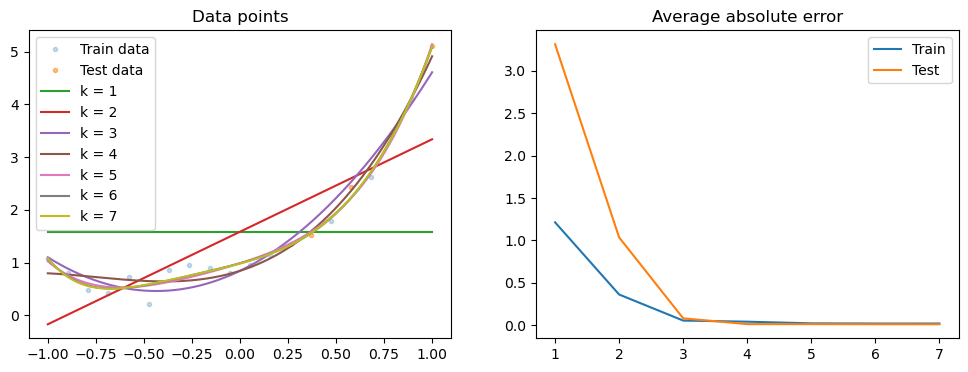

In [31]:
ks = [k for k in range(1,8)]
plot_data(ks, fit_MLE, GD, lamb=None)

### Stochastic Gradient Descent

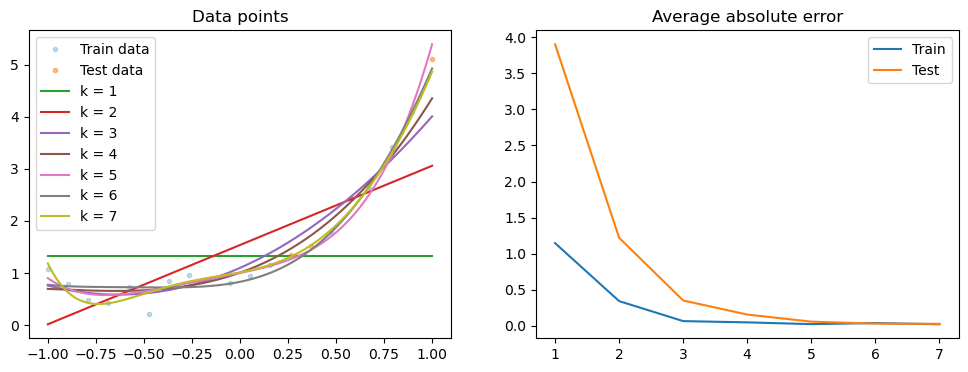

In [53]:
ks = [k for k in range(1,8)]
plot_data(ks, fit_MLE, SGD, lamb=None)

### Normal Equation

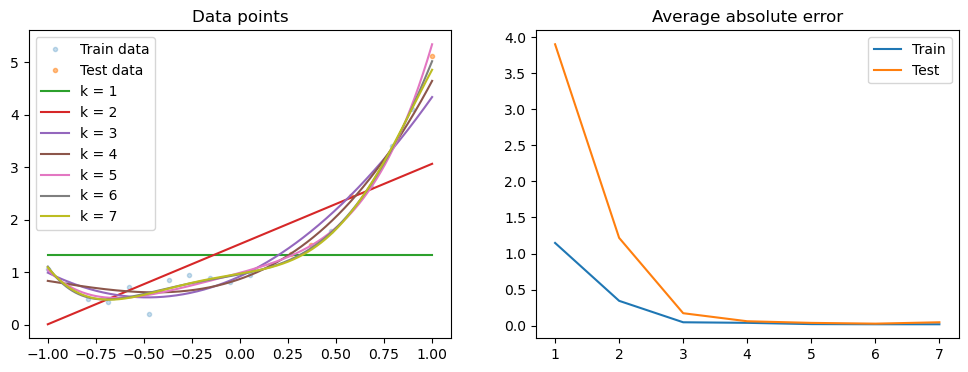

In [24]:
ks = [k for k in range(1,8)]
plot_data(ks, fit_MLE, NEQ, lamb=None)

# Maximum a Posteriori Estimation

In this section MAP is used with different minimizin methods.

Fixed $\lambda$, varying k

### Gradient Descent

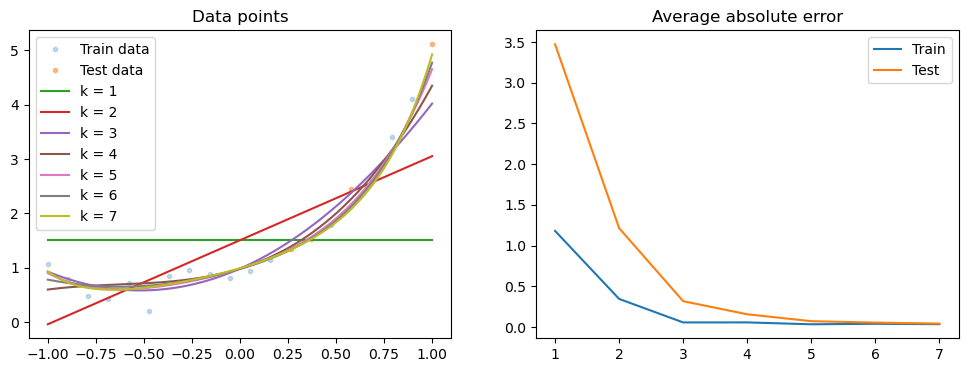

In [34]:
ks = [k for k in range(1,8)]
lamb = 1
plot_data(ks, fit_MAP, GD, lamb)

### Stochastic Gradient Descent

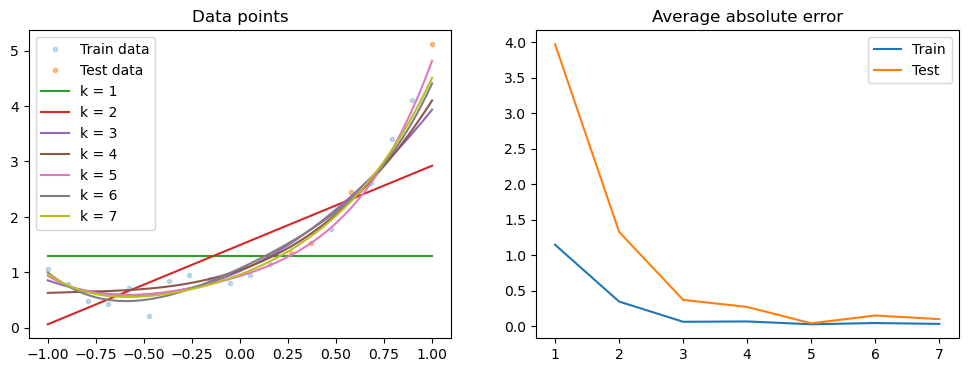

In [35]:
ks = [k for k in range(1,8)]
lamb = 1
plot_data(ks, fit_MAP, SGD, lamb)

### Normal Equations

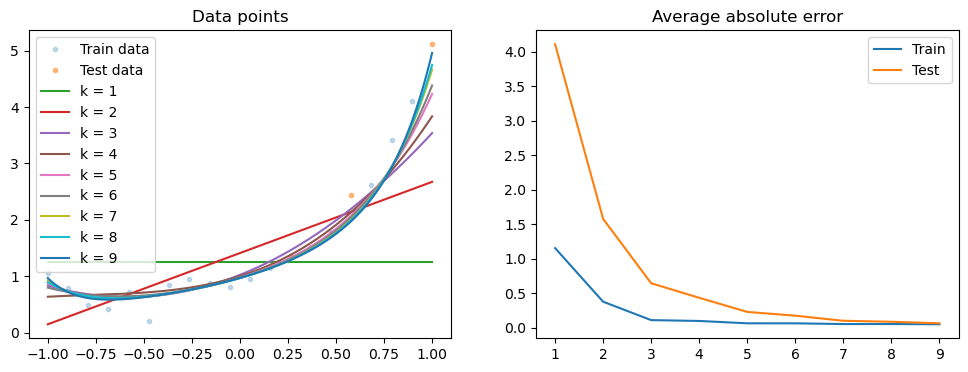

In [36]:
ks = [k for k in range(1,10)]
lamb = 1
plot_data(ks, fit_MAP, NEQ, lamb)

Fixed k, varing $\lambda$  

Varying lambda with fixed k = 3


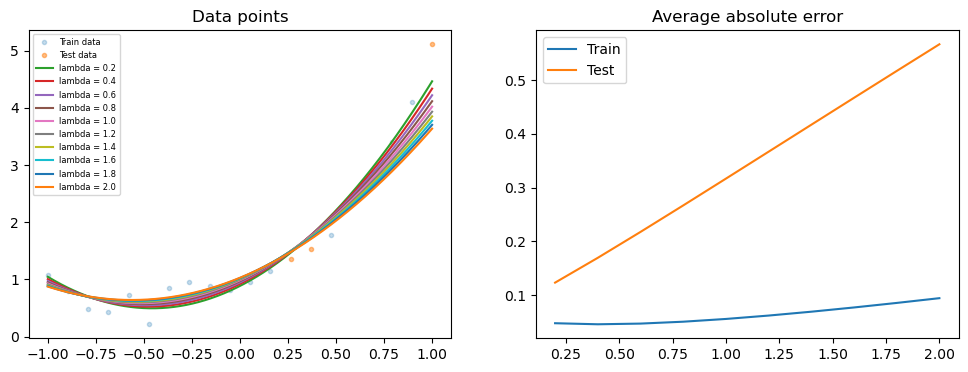

Varying lambda with fixed k = 7


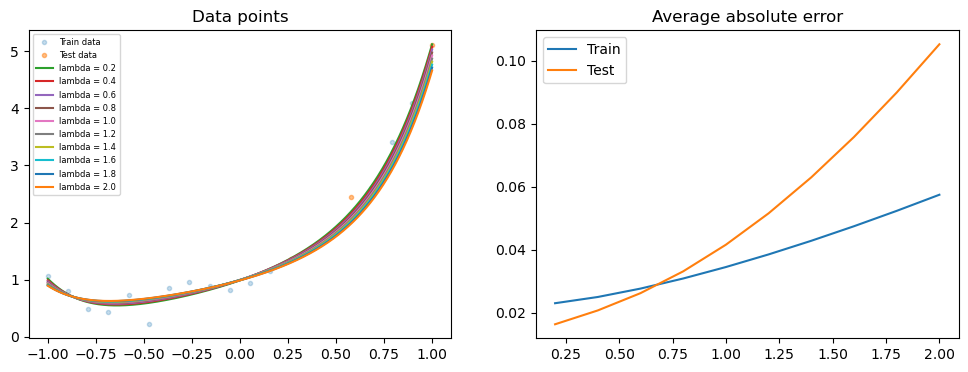

Varying lambda with fixed k = 15


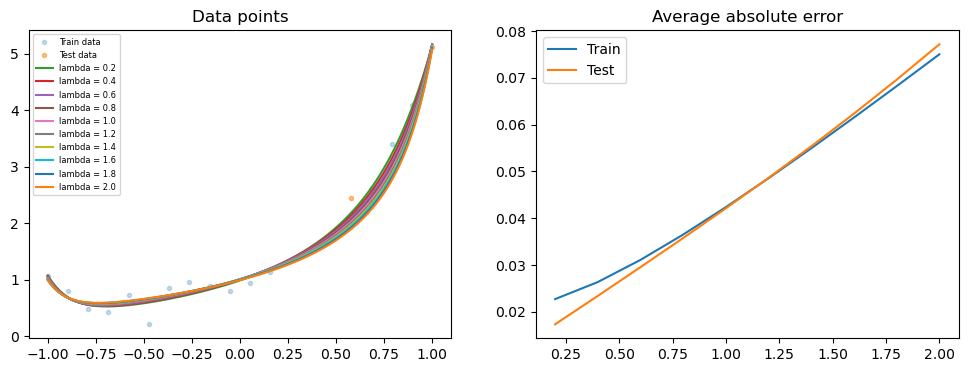

In [37]:
ks = [K-2, K+2, K+10]
lambs = np.arange(0.2,2.1,0.2)
for k in ks:
    print(f"Varying lambda with fixed k = {k}")
    plot_data_varying_lambda(k, lambs, GD)

## Comparing different minimization methods

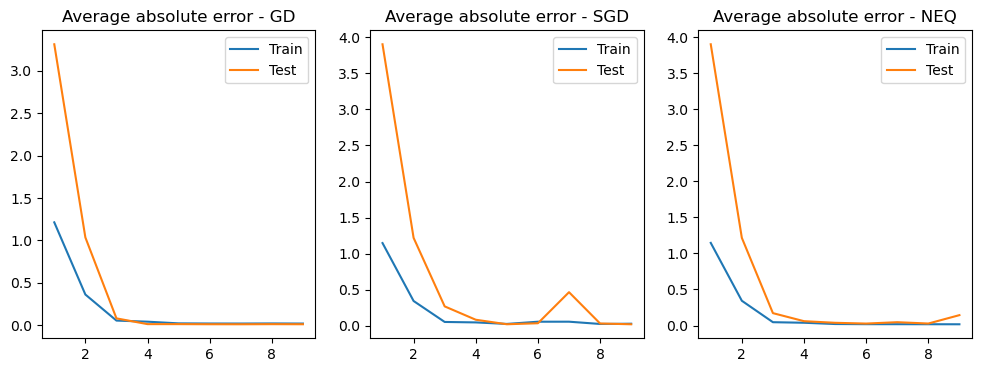

In [44]:
ks = [k for k in range(1,10)]
plot_and_compare_minimum(ks, fit_MLE, lamb)

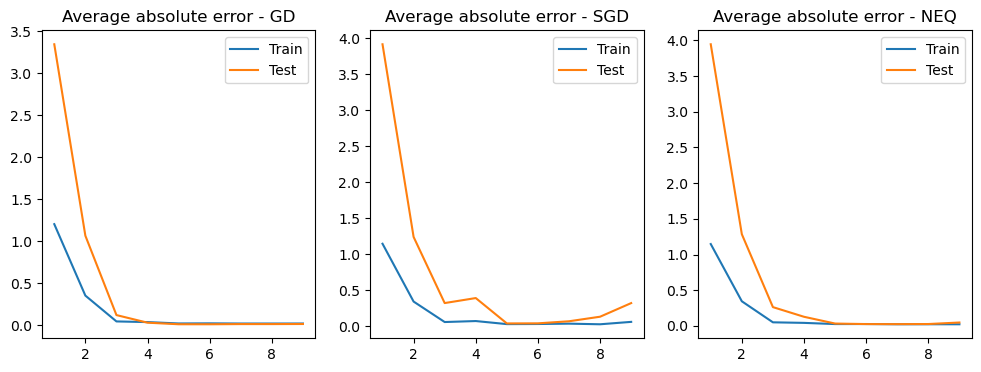

In [45]:
ks = [k for k in range(1,10)]
lamb = 0.2
plot_and_compare_minimum(ks, fit_MAP, lamb)

# MLE vs MAP:
In this section MLE vs MAP is studied, considering both k and N (dataset dimension)

### Average absolute error and theta error, with respect to k.

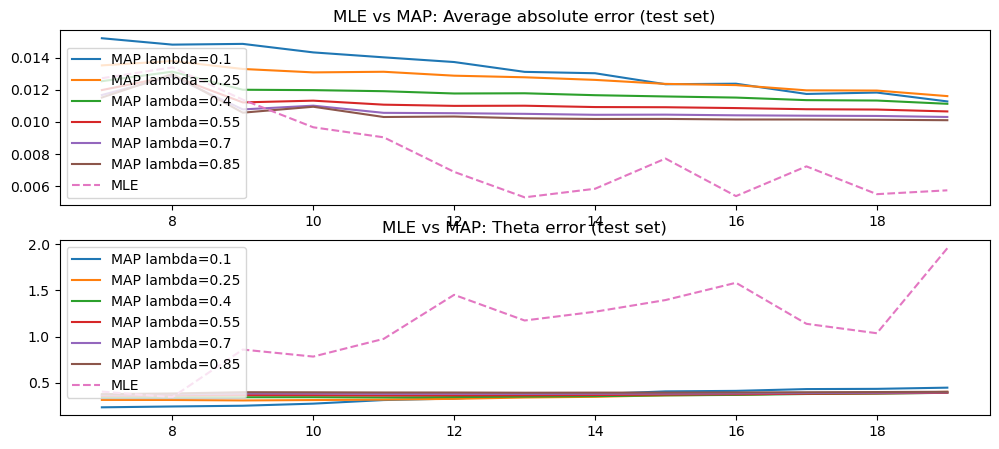

In [93]:
ks = [K + k for k in range(2,15)]
lambs = np.arange(0.1,1,0.15)
plot_and_compare(ks, lambs, GD)

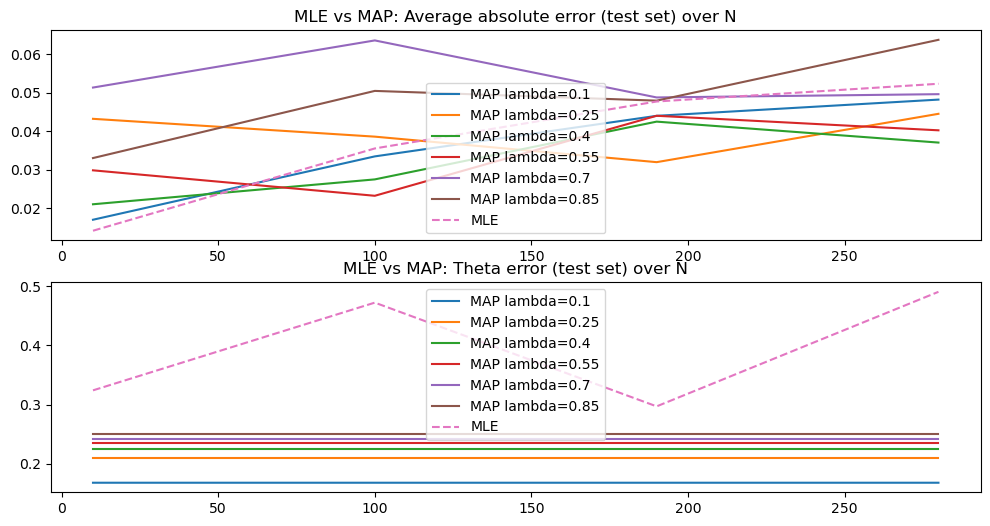

In [47]:
k = K
lambs = np.arange(0.1,1,0.15)
# granularity = 10
Ns = np.array([10,100,190,280])
plot_and_compare_varying_N(k, lambs, GD, Ns)

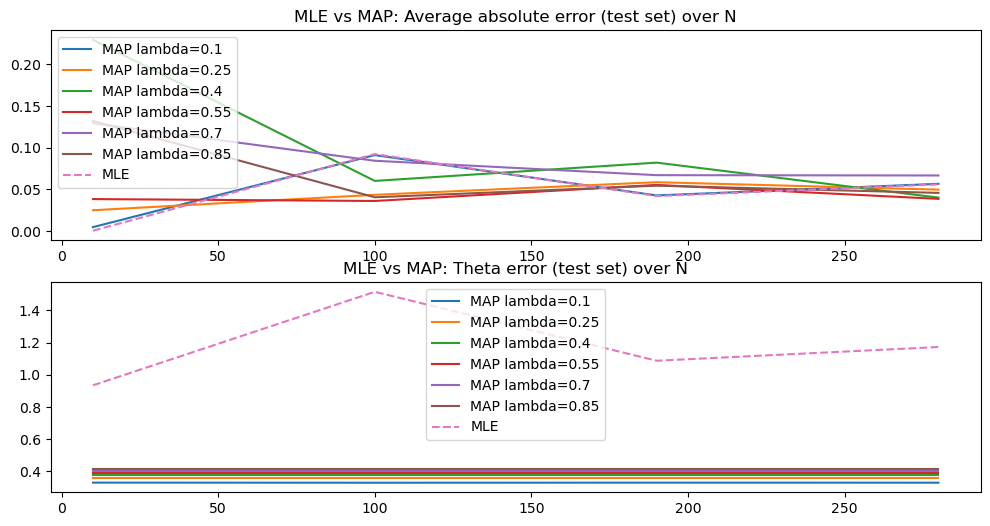

In [54]:
k = K+10
lambs = np.arange(0.1,1,0.15)
# granularity = 10
Ns = np.array([10,100,190,280])
plot_and_compare_varying_N(k, lambs, GD, Ns)